
# Self-Driving Car Engineer Nanodegree
## Project 4: (Deep Learning) Driving Behavioral Cloning

In this project, I used what I've learned about deep neural networks and convolutional neural networks to clone driving behavior. I trained, validated and tested a model using Keras. The model will output a steering angle to an autonomous vehicle.

#### DEPENDENCIES:
pip install "python-socketio[client]"  
sudo python3 -m pip install eventlet  
sudo python3 -m pip install flask  

#### TODO:
Data augmentation  
draw loss

In [1]:
# Importing useful packages

from utils import load_dataset, plot_data_distribution
from utils import create_video, reproduce_dataset

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

import matplotlib.pyplot as plt
import numpy as np


Using TensorFlow backend.


---
## Step 1: Dataset Loading, Summary and Exploration

Te data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of car's cameras
- `'y_train'` is a 1D array containing the stering value

In [2]:
# Hyper Parameters
DOWN_LIMIT = 20 # Down Horizontal limits to crop dataset
UP_LIMIT = 65 # Up Horizontal limits to crop dataset
CORRECTION = 0.2 # Correction factor for stearing angles


### Dataset Loading and Basic Summay

Number of training samples: 4835
Shape of training samples:(160, 320, 3)


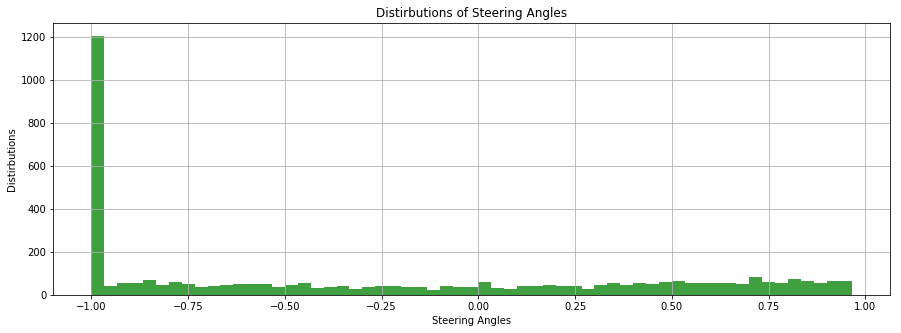

In [17]:
# Load dataset
dataset_path = os.path.join("self-driving-data-capture/stage_1_03312019", "driving_log.csv")
# dataset_path = os.path.join("self-driving-data-capture/stage_1_zig_zag_03312019", "driving_log.csv")
# dataset_path = os.path.join("self-driving-data-capture/stage_2_03312019", "driving_log.csv")
X_train_c, X_train_l, X_train_r, y_train = load_dataset(dataset_path)
src_shape = X_train_c.shape[1:] # Image shape

# Print dataset information
print("Number of training samples: {}".format(len(X_train_c))) # Number of training examples
print("Shape of training samples:{}".format(src_shape)) # Samples shape

# Plot dataset distribution
plot_data_distribution(y_train, scfc=30)


### Exploratory Visualization of the Dataset

In [7]:
# Create videos with current datasets
create_video(X_train_c, "dataset_videos", "03302019_center_camera.mp4")
create_video(X_train_l, "dataset_videos", "03302019_left_camera.mp4")
create_video(X_train_r, "dataset_videos", "03302019_right_camera.mp4")


In [8]:
# Concatenate cameras videos and reproduce
X_train = np.asarray([np.concatenate(img, axis = 0) for img in zip(X_train_r, X_train_c, X_train_l)])
reproduce_dataset(X_train_c, fps=30, loop=True, sc_fc=1.5, up_limit=UP_LIMIT, down_limit=DOWN_LIMIT) # A: Stop video - Q: Quit


### Data Augmentation:  Data Set Pre-processing

## Step 2: Designing, Training and Testing a Model Architecture

### Data Pre-processing

### Model Training

In [ ]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=src_shape))
model.add(Cropping2D(cropping=((DOWN_LIMIT, UP_LIMIT),(0, 0))))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
# model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
model.fit(X_train_c, y_train, validation_split=0.2, shuffle=True, nb_epoch=5, verbose=1)
model.save('model/behavioral_model.h5')


### Plot Testing Results

### Run Simulaion Model and SImulation Enviroment

In [ ]:
from multiprocessing import Pool 
import os

def run_process(process):                                                             
    os.system('{}'.format(process)) 
     7
processes = (
    "clear && {}".format(os.path.join(os.getcwd(), "beta_simulator_linux", "beta_simulator.x86_64")),
    "clear && termdown 10 && clear && python3 {} {} {}".format(
        os.path.join(os.getcwd(), "drive.py"), 
        os.path.join(os.getcwd(), "model", "behavioral_model.h5"), 
        os.path.join(os.getcwd(), "model_resuts")))
pool = Pool(processes=len(processes))                                                        
pool.map(run_process, processes)


In [13]:
# Run only simulation enviroment
import os
os.system('{}'.format(os.path.join(os.getcwd(), "beta_simulator_linux", "beta_simulator.x86_64"))) 

0